# Libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd
import pandas_datareader as web
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import seaborn as sns
sns.set()

# Efficient Frontier Functions (from Codecademy)

In [2]:
# Return Portfolio Function
def return_portfolios(expected_returns, cov_matrix):
    np.random.seed(1)
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected) 
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
        portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
    for counter,symbol in enumerate(selected):
        portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
    df = df[column_order]
   
    return df

In [3]:
# Optimal Portfolio Function
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.values)

    N = 10
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

# Stocks and Period Selection

In [4]:
# Stocks selected: JP Morgan, Novo Nordisk, Spotify, Amazon, Shell, Disney, Microsoft, Louis Vuitton; Period: 01.01.2020 - 30.05.2025
name_stocks = ['JPM', 'LLY', 'SPOT', 'AMZN', 'SHEL', 'NFLX', 'MSFT', 'LVMUY']
name = ['JP Morgan', 'Lily', 'Spotify', 'Amazon', 'Shell', 'Netflix', 'Microsoft', 'Louis Vuitton']

start = datetime(2020, 1, 1)
end = datetime(2025, 5, 30)

# Import Stocks Data

In [5]:
# import stock prices from yahoo finance
stock_df = yf.download(name_stocks, start, end, interval='1d', auto_adjust=True) # daily stock data for analysis
stock_df_qtr = yf.download(name_stocks, start, end, interval='3mo', auto_adjust=True) # quarterly stock data for plot
stock_df.head()

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed


Price           Close                                                 \
Ticker           AMZN         JPM         LLY      LVMUY        MSFT   
Date                                                                   
2020-01-02  94.900497  120.733536  123.449280  87.191139  153.042297   
2020-01-03  93.748497  119.140320  123.038414  86.414299  151.136658   
2020-01-06  95.143997  119.045555  123.495918  86.395805  151.527313   
2020-01-07  95.343002  117.021736  123.729370  85.581970  150.145706   
2020-01-08  94.598503  117.934624  124.849861  86.284828  152.537292   

Price                                               High              ...  \
Ticker            NFLX       SHEL        SPOT       AMZN         JPM  ...   
Date                                                                  ...   
2020-01-02  329.809998  48.133717  151.619995  94.900497  120.742101  ...   
2020-01-03  325.899994  48.512394  152.500000  94.309998  119.906800  ...   
2020-01-06  335.829987  49.116692  156.720001  95.184502  119.080011  ...   
2020-01-07  330.750000  48.665493  156.020004  95.694504  118.726936  ...   
2020-01-08  339.260010  48.093433  158.779999  95.550003  118.485800  ...   

Price            Open                Volume                             \
Ticker           SHEL        SPOT      AMZN       JPM      LLY   LVMUY   
Date                                                                     
2020-01-02  47.908113  151.000000  80580000  10803700  2204200  104400   
2020-01-03  48.246508  149.500000  75288000  10386800  1963500   74500   
2020-01-06  49.116692  151.490005  81236000  10259000  2102900   77500   
2020-01-07  48.625205  156.699997  80898000  10531300  2448300  155100   
2020-01-08  48.190122  156.330002  70160000   9695300  5188600  105000   

Price                                            
Ticker          MSFT     NFLX     SHEL     SPOT  
Date                                             
2020-01-02  22622100  4485800  3085246   662600  
2020-01-03  21116200  3806900  3713515  1018400  
2020-01-06  20813700  5663100  3250736  1311900  
2020-01-07  21634100  4703200  2683199   876700  
2020-01-08  27746500  7104500  2966175   974500  

[5 rows x 40 columns]

# Calculated Adjusted Returns

In [6]:
stock_adj_close = stock_df.Close # daily adjusted close
stock_adj_close_qtr = stock_df_qtr.Close # quarterly adjusted close
daily_stock_adj_return = stock_adj_close.pct_change() # daily adjusted returns
qtr_stock_adj_return = stock_adj_close_qtr.pct_change() # quarterly adjusted returns
date_label = qtr_stock_adj_return.reset_index() # df for date ticks and labels for x-axis
qtr = date_label.Date # df for quarters only for x-axis
daily_stock_adj_return.head(30)

Ticker,AMZN,JPM,LLY,LVMUY,MSFT,NFLX,SHEL,SPOT
Date,,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.012139,-0.013196,-0.003328,-0.008910,-0.012452,-0.011855,0.007867,0.005804
2020-01-06,0.014886,-0.000795,0.003718,-0.000214,0.002585,0.030469,0.012457,0.027672
2020-01-07,0.002092,-0.017000,0.001890,-0.009420,-0.009118,-0.015127,-0.009186,-0.004467
2020-01-08,-0.007809,0.007801,0.009056,0.008213,0.015928,0.025729,-0.011755,0.017690
2020-01-09,0.004799,0.003651,0.016529,0.012862,0.012493,-0.010611,-0.000168,-0.006550
2020-01-10,-0.009411,-0.009968,0.015303,-0.004444,-0.004627,-0.019693,-0.011227,-0.010777
2020-01-13,0.004323,0.008304,0.006812,0.014775,0.012024,0.029996,-0.000847,-0.033133
2020-01-14,-0.011558,0.011662,0.012307,0.002409,-0.007043,-0.000679,-0.000678,-0.009743


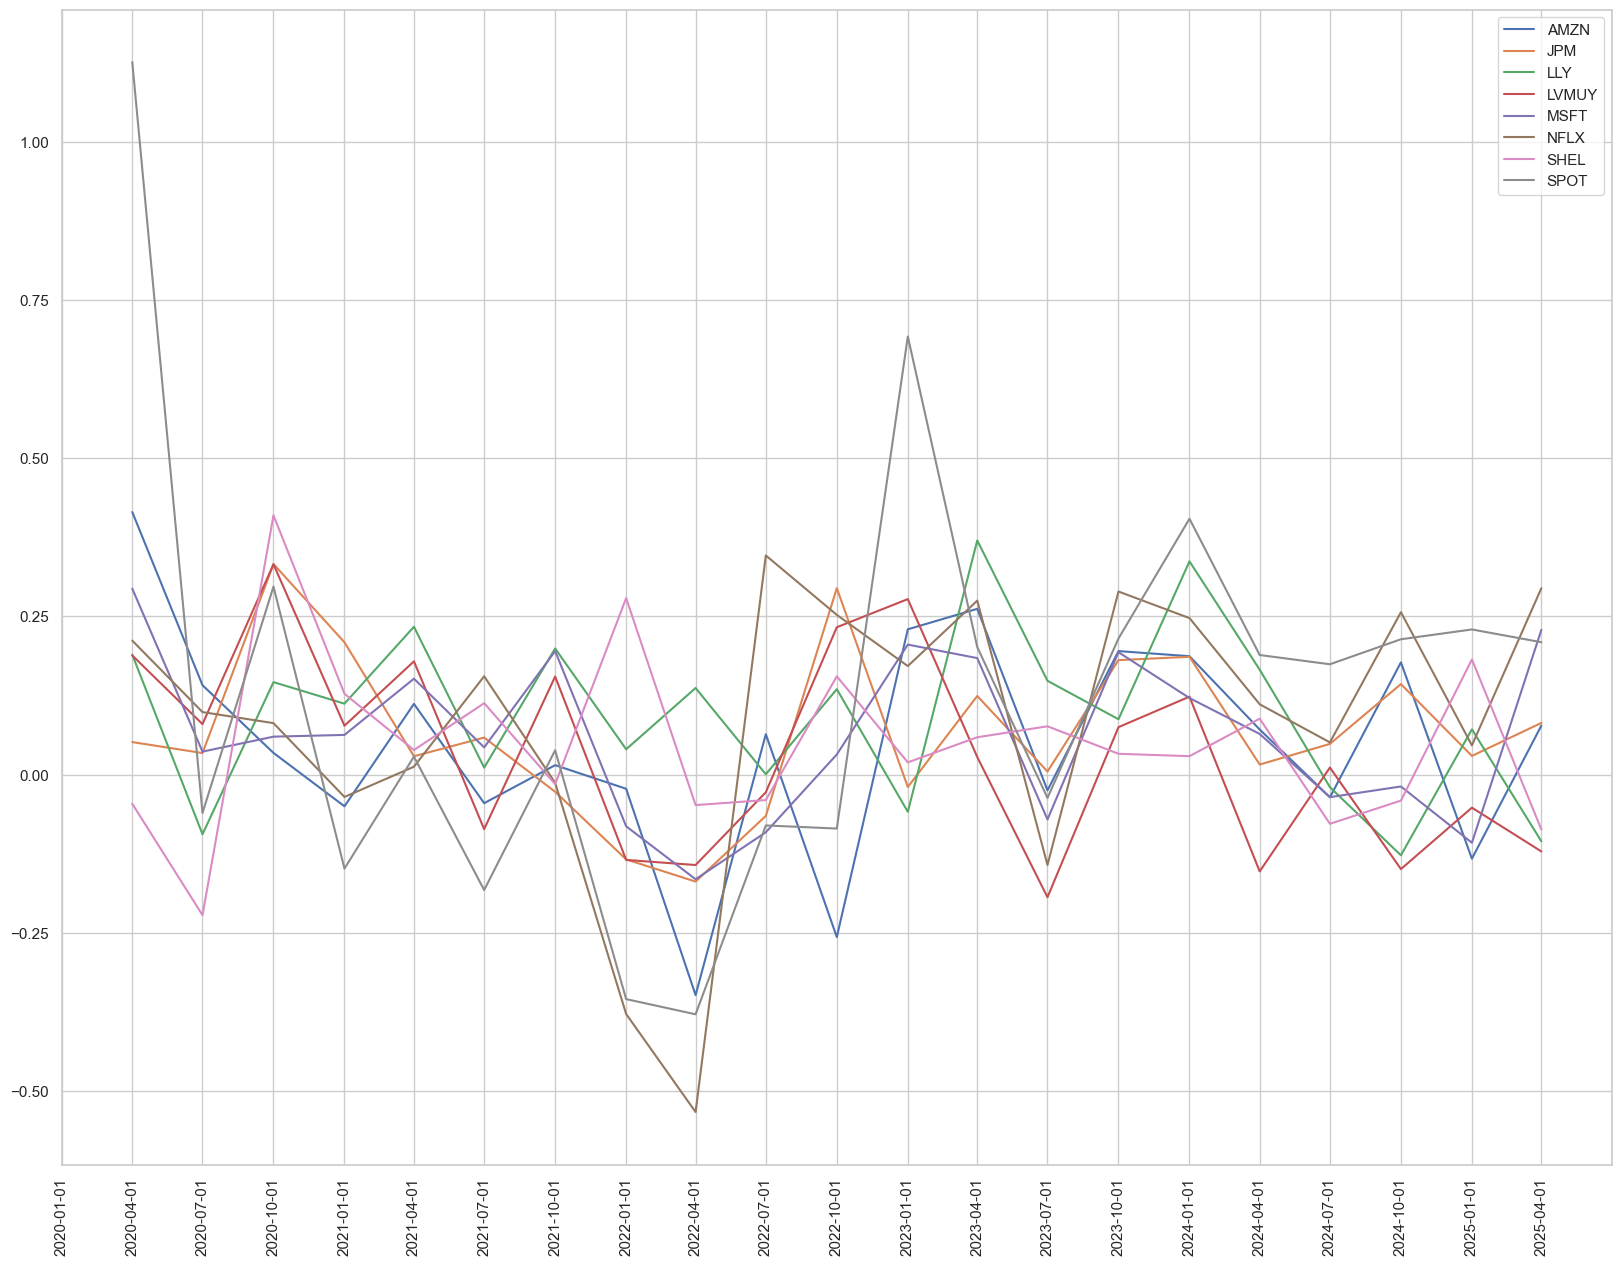

In [7]:
# plot of quarterly stock returns for all stocks
sns.set_style('whitegrid')
plt.figure(figsize=(20,15))
ax = plt.subplot()
plt.plot(qtr_stock_adj_return)
plt.legend(sorted(name_stocks))
ax.set_xticks(qtr)
ax.set_xticklabels(pd.to_datetime(qtr).dt.date)
plt.xticks(rotation=90)
plt.show()

# Financial Statistics

In [8]:
# annualized mean simple return by stock for the period
mean_simple_return = daily_stock_adj_return.mean()
ann_mean_simple_return = mean_simple_return.apply(lambda x: (1 + x) ** 250 - 1)
mean_simple_return
ann_mean_simple_return

Ticker
AMZN     0.230862
JPM      0.216839
LLY      0.463772
LVMUY    0.104914
MSFT     0.282080
NFLX     0.404420
SHEL     0.134676
SPOT     0.474470
dtype: float64

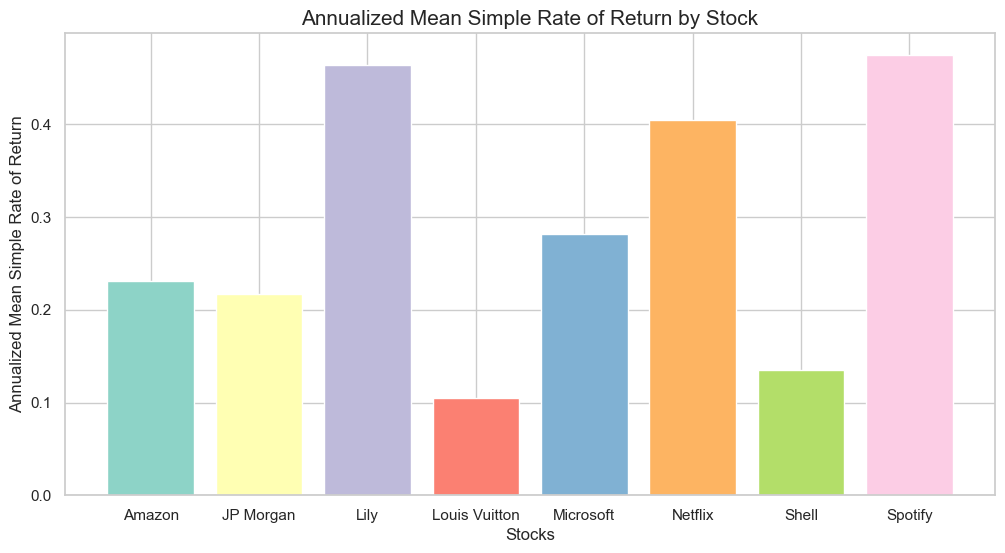

In [9]:
# bar chart showing annualized stock returns
qualitative_colors = sns.color_palette('Set3',10)
sns.set_palette(qualitative_colors)
f = plt.figure(figsize=(12,6))
ax = f.add_subplot()
ax.bar(list(range(len(ann_mean_simple_return))),ann_mean_simple_return, color=qualitative_colors)
ax.set_xlabel('Stocks')
ax.set_ylabel('Annualized Mean Simple Rate of Return')
ax.set_xticks(list(range(len(ann_mean_simple_return))))
ax.set_xticklabels(sorted(name))
plt.title('Annualized Mean Simple Rate of Return by Stock', fontsize=15)
plt.savefig('mean.png')
plt.show()

In [10]:
# risk (std deviation) by stock for the period
stock_std = daily_stock_adj_return.std()
stock_std

Ticker
AMZN     0.022887
JPM      0.020435
LLY      0.021296
LVMUY    0.021716
MSFT     0.019290
NFLX     0.028415
SHEL     0.023053
SPOT     0.031554
dtype: float64

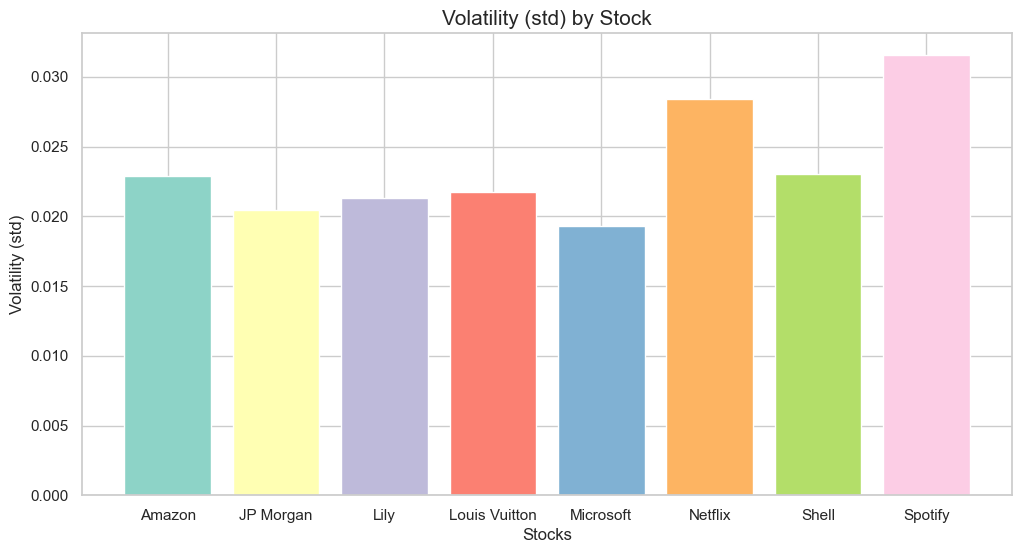

In [11]:
# bar chart showing annualized stock returns
qualitative_colors = sns.color_palette('Set3',10)
sns.set_palette(qualitative_colors)
f = plt.figure(figsize=(12,6))
ax = f.add_subplot()
ax.bar(list(range(len(stock_std))),stock_std, color=qualitative_colors)
ax.set_xlabel('Stocks')
ax.set_ylabel('Volatility (std)')
ax.set_xticks(list(range(len(stock_std))))
ax.set_xticklabels(sorted(name))
plt.title('Volatility (std) by Stock', fontsize=15)
plt.savefig('std.png')
plt.show()

In [12]:
# overview of individual stock risk and return
risk_return = pd.DataFrame([ann_mean_simple_return, stock_std], index = ['Annual Return', 'Risk (std)'])
risk_return

Ticker,AMZN,JPM,LLY,LVMUY,MSFT,NFLX,SHEL,SPOT
Annual Return,0.230862,0.216839,0.463772,0.104914,0.28208,0.404420,0.134676,0.474470
Risk (std),0.022887,0.020435,0.021296,0.021716,0.01929,0.028415,0.023053,0.031554


In [13]:
# covariance matrix for the selected stocks
stock_cov = daily_stock_adj_return.cov()
stock_cov

Ticker,AMZN,JPM,LLY,LVMUY,MSFT,NFLX,SHEL,SPOT
Ticker,,,,,,,,
AMZN,0.000524,0.000141,0.000114,0.000203,0.000303,0.000349,0.000090,0.000353
JPM,0.000141,0.000418,0.000103,0.000225,0.000171,0.000125,0.000265,0.000159
LLY,0.000114,0.000103,0.000454,0.000094,0.000138,0.000120,0.000081,0.000101
LVMUY,0.000203,0.000225,0.000094,0.000472,0.000210,0.000194,0.000218,0.000205
MSFT,0.000303,0.000171,0.000138,0.000210,0.000372,0.000268,0.000128,0.000273
NFLX,0.000349,0.000125,0.000120,0.000194,0.000268,0.000807,0.000081,0.000445
SHEL,0.000090,0.000265,0.000081,0.000218,0.000128,0.000081,0.000531,0.000106
SPOT,0.000353,0.000159,0.000101,0.000205,0.000273,0.000445,0.000106,0.000996


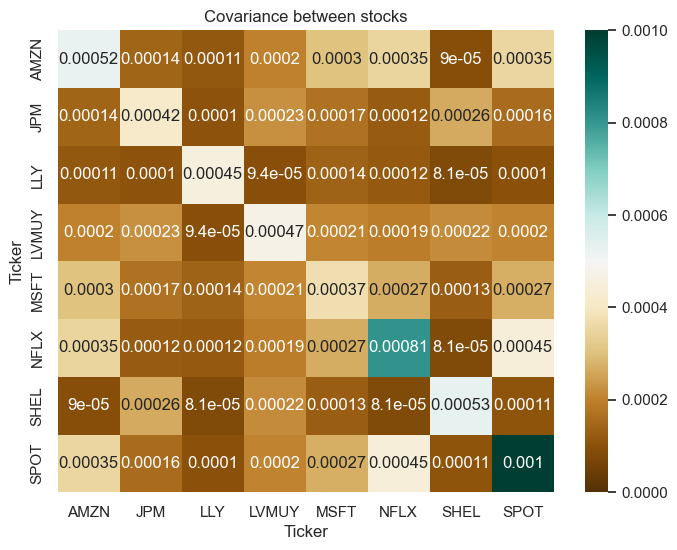

In [14]:
# heatmap to show covariance of stocks
plt.figure(figsize=(8, 6))
sns.heatmap(stock_cov, vmin=0, vmax=0.001, annot=True, cmap='BrBG')
plt.title('Covariance between stocks')
plt.savefig('cov_heat.png')
plt.show()

In [15]:
# correlation matrix for the selected stocks
stock_corr = daily_stock_adj_return.corr()
stock_corr

Ticker,AMZN,JPM,LLY,LVMUY,MSFT,NFLX,SHEL,SPOT
Ticker,,,,,,,,
AMZN,1.000000,0.302213,0.233518,0.407836,0.685383,0.536733,0.170979,0.489332
JPM,0.302213,1.000000,0.237557,0.507678,0.434049,0.214441,0.561690,0.246790
LLY,0.233518,0.237557,1.000000,0.203449,0.335267,0.197888,0.165784,0.151009
LVMUY,0.407836,0.507678,0.203449,1.000000,0.501588,0.314052,0.434787,0.298681
MSFT,0.685383,0.434049,0.335267,0.501588,1.000000,0.489223,0.287856,0.448223
NFLX,0.536733,0.214441,0.197888,0.314052,0.489223,1.000000,0.123749,0.496599
SHEL,0.170979,0.561690,0.165784,0.434787,0.287856,0.123749,1.000000,0.145577
SPOT,0.489332,0.246790,0.151009,0.298681,0.448223,0.496599,0.145577,1.000000


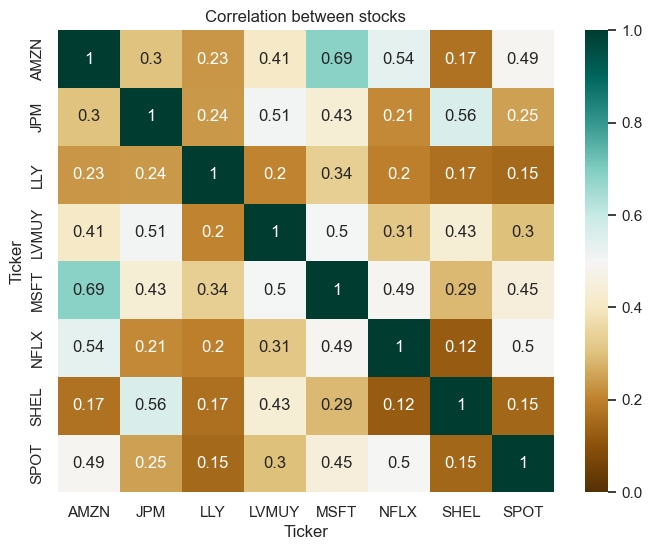

In [16]:
# heatmap to show correlation of stocks
plt.figure(figsize=(8, 6))
sns.heatmap(stock_corr, vmin=0, vmax=1, annot=True, cmap='BrBG')
plt.title('Correlation between stocks')
plt.savefig('corr_heat.png')
plt.show()

# Efficient Frontier

In [17]:
# generation of random portfolios
random_portfolios = return_portfolios(mean_simple_return, stock_cov)
random_portfolios.head()

,Returns,Volatility,AMZN Weight,JPM Weight,LLY Weight,LVMUY Weight,MSFT Weight,NFLX Weight,SHEL Weight,SPOT Weight
0,0.000876,0.016332,0.188637,0.325834,0.000052,0.136758,0.066384,0.041769,0.084254,0.156312
1,0.001078,0.016945,0.103854,0.141036,0.109725,0.179357,0.053516,0.229848,0.007169,0.175496
2,0.001082,0.017228,0.102050,0.136625,0.034331,0.048445,0.195818,0.236783,0.076646,0.169304
3,0.001052,0.017540,0.253107,0.258368,0.024561,0.011279,0.049048,0.253614,0.028403,0.121619
4,0.001125,0.016750,0.200060,0.111354,0.144502,0.065897,0.143379,0.174316,0.003820,0.156672


In [18]:
# generation of optimal portfolio
weights, returns, risks = optimal_portfolio(daily_stock_adj_return[1:])

     pcost       dcost       gap    pres   dres
 0: -9.8392e-04 -1.0015e+00  1e+00  2e-16  3e+00
 1: -9.8426e-04 -1.1533e-02  1e-02  8e-17  3e-02
 2: -1.0151e-03 -1.6322e-03  6e-04  9e-17  2e-03
 3: -1.4983e-03 -1.7227e-03  2e-04  2e-16  3e-04
 4: -1.5168e-03 -1.5221e-03  5e-06  1e-16  7e-06
 5: -1.5192e-03 -1.5192e-03  6e-08  1e-16  8e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.5839e-04 -1.0015e+00  1e+00  3e-16  3e+00
 1: -9.5872e-04 -1.1515e-02  1e-02  9e-17  3e-02
 2: -9.8889e-04 -1.6137e-03  6e-04  5e-17  2e-03
 3: -1.4645e-03 -1.7032e-03  2e-04  8e-16  2e-04
 4: -1.4757e-03 -1.4809e-03  5e-06  2e-16  4e-06
 5: -1.4785e-03 -1.4786e-03  6e-08  1e-16  5e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.7766e-04 -1.0015e+00  1e+00  2e-16  3e+00
 1: -8.7798e-04 -1.1492e-02  1e-02  1e-16  3e-02
 2: -9.0622e-04 -1.5879e-03  7e-04  8e-17  2e-03
 3: -1.3367e-03 -1.6615e-03  3e-04  2e-16  2e-05
 4: -1.3501e-03 -1.3833e

single_asset_std = np.sqrt(np.diagonal(stock_cov))

random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12, figsize=(12,6))
plt.plot(risks, returns, 'g-o')
plt.scatter(single_asset_std, mean_simple_return, marker='X',color='red',s=200)
plt.axis([0.01, 0.04, 0, 0.002])    
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (std)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
for i, txt in enumerate(daily_stock_adj_return.keys()):
    plt.annotate(txt, (single_asset_std[i], mean_simple_return[i]), size=12, xytext=(4,7), ha='left', textcoords='offset points')
plt.show()

# Portfolio Characteristics

In [20]:
min_volatility = random_portfolios.Volatility.min() # minimum volatility of portfolios
max_volatility = random_portfolios.Volatility.max() # maximum volatility of portfolios
min_returns = random_portfolios.Returns.min() # minimum return of portfolios
max_returns = random_portfolios.Returns.max() # maximum return of portfolios

print(min_volatility,max_volatility)
print(min_returns,max_returns)


0.014371989500721154 0.02017244580467083
0.0006563469790795415 0.0013657079840281169


# Recommended Portfolio

In [40]:
recom_portfolio = pd.DataFrame([random_portfolios.iloc[i] for i in range(5000) \
                    if (random_portfolios.Returns[i] > 0.0013) \
                    and (random_portfolios.Volatility[i] < 0.018)])

recom_portfolio

,Returns,Volatility,AMZN Weight,JPM Weight,LLY Weight,LVMUY Weight,MSFT Weight,NFLX Weight,SHEL Weight,SPOT Weight
232,0.001327,0.017472,0.011316,0.044409,0.277782,0.013294,0.112150,0.186377,0.059296,0.295377
1010,0.001366,0.016811,0.064717,0.003696,0.472574,0.022938,0.050702,0.220106,0.026174,0.139092


# Optimal Portfolio is Portfolio 1010